In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

The purpose of this notebook is to find a scaling law which fit the GOLEM shot confinement times. The data have been collected from shot #21000 to #29162 of the GOLEM shot database, using the following URL :
http://golem.fjfi.cvut.cz/utils/miner?new_diagn=input_power_plasma_mean&action=Add&xaxis=ShotNo&start_shot=21000&end_shot=29162&diagn_0=breakdown_field&filter_0=none&subplot_0=&yrange0_0=&yrange1_0=&scale_0=linear&diagn_1=breakdown_probability&filter_1=none&subplot_1=&yrange0_1=&yrange1_1=&scale_1=linear&diagn_2=breakdown_rate&filter_2=none&subplot_2=&yrange0_2=&yrange1_2=&scale_2=linear&diagn_3=breakdown_rate_err&filter_3=none&subplot_3=&yrange0_3=&yrange1_3=&scale_3=linear&diagn_4=breakdown_time&filter_4=none&subplot_4=&yrange0_4=&yrange1_4=&scale_4=linear&diagn_5=breakdown_voltage&filter_5=none&subplot_5=&yrange0_5=&yrange1_5=&scale_5=linear&diagn_6=cb&filter_6=none&subplot_6=&yrange0_6=&yrange1_6=&scale_6=linear&diagn_7=cbd&filter_7=none&subplot_7=&yrange0_7=&yrange1_7=&scale_7=linear&diagn_8=ccd&filter_8=none&subplot_8=&yrange0_8=&yrange1_8=&scale_8=linear&diagn_9=cst&filter_9=none&subplot_9=&yrange0_9=&yrange1_9=&scale_9=linear&diagn_10=chamber_inductance&filter_10=none&subplot_10=&yrange0_10=&yrange1_10=&scale_10=linear&diagn_11=chamber_resistance&filter_11=none&subplot_11=&yrange0_11=&yrange1_11=&scale_11=linear&diagn_12=chamber_temperature&filter_12=none&subplot_12=&yrange0_12=&yrange1_12=&scale_12=linear&diagn_13=discharge_aborted&filter_13=none&subplot_13=&yrange0_13=&yrange1_13=&scale_13=linear&diagn_14=electron_confinement_t98&filter_14=none&subplot_14=&yrange0_14=&yrange1_14=&scale_14=linear&diagn_15=electron_confinement_time&filter_15=none&subplot_15=&yrange0_15=&yrange1_15=&scale_15=linear&diagn_16=electron_temperature_max&filter_16=none&subplot_16=&yrange0_16=&yrange1_16=&scale_16=linear&diagn_17=lb&filter_17=none&subplot_17=&yrange0_17=&yrange1_17=&scale_17=linear&diagn_18=loop_voltage_max&filter_18=none&subplot_18=&yrange0_18=&yrange1_18=&scale_18=linear&diagn_19=loop_voltage_mean&filter_19=none&subplot_19=&yrange0_19=&yrange1_19=&scale_19=linear&diagn_20=plasma&filter_20=none&subplot_20=&yrange0_20=&yrange1_20=&scale_20=linear&diagn_21=plasma_life&filter_21=none&subplot_21=&yrange0_21=&yrange1_21=&scale_21=linear&diagn_22=toroidal_field_mean&filter_22=none&subplot_22=&yrange0_22=&yrange1_22=&scale_22=linear&diagn_23=toroidal_field_max&filter_23=none&subplot_23=&yrange0_23=&yrange1_23=&scale_23=linear&diagn_24=ub&filter_24=none&subplot_24=&yrange0_24=&yrange1_24=&scale_24=linear&diagn_25=ubd&filter_25=none&subplot_25=&yrange0_25=&yrange1_25=&scale_25=linear&diagn_26=ucd&filter_26=none&subplot_26=&yrange0_26=&yrange1_26=&scale_26=linear&diagn_27=ust&filter_27=none&subplot_27=&yrange0_27=&yrange1_27=&scale_27=linear&diagn_28=tst&filter_28=none&subplot_28=&yrange0_28=&yrange1_28=&scale_28=linear&diagn_29=tcd&filter_29=none&subplot_29=&yrange0_29=&yrange1_29=&scale_29=linear&diagn_30=tb&filter_30=none&subplot_30=&yrange0_30=&yrange1_30=&scale_30=linear&diagn_31=tbd&filter_31=none&subplot_31=&yrange0_31=&yrange1_31=&scale_31=linear&diagn_32=pressure&filter_32=none&subplot_32=&yrange0_32=&yrange1_32=&scale_32=linear&diagn_33=pressure_chamber&filter_33=none&subplot_33=&yrange0_33=&yrange1_33=&scale_33=linear&diagn_34=pressure_initial&filter_34=none&subplot_34=&yrange0_34=&yrange1_34=&scale_34=linear&diagn_35=pressure_request&filter_35=none&subplot_35=&yrange0_35=&yrange1_35=&scale_35=linear&diagn_36=plasma_current_mean&filter_36=none&subplot_36=&yrange0_36=&yrange1_36=&scale_36=linear&diagn_37=plasma_current_decay&filter_37=none&subplot_37=&yrange0_37=&yrange1_37=&scale_37=linear&diagn_38=zeff&filter_38=none&subplot_38=&yrange0_38=&yrange1_38=&scale_38=linear&diagn_39=input_power_mean&filter_39=none&subplot_39=&yrange0_39=&yrange1_39=&scale_39=linear

In [7]:
# open the shot database
dataset = pd.read_csv('close_shots.txt', delimiter='\s+', index_col='shots')
dataset['R'] = 0.4 # add the Vessel Major Radius column
dataset['a'] = 0.06 # add the Plasma minor Radius column

# Cleaning the data

Next we clean the data according to these [recommandations](http://golem.fjfi.cvut.cz/wiki/Handling/DataMining/data_mining) to avoid failed shot and NaN data

In [8]:
print('Initial size of the dataset before cleaning: ', dataset.size)

# Drop vacuum shots
dataset = dataset.drop(dataset[dataset['plasma'] != 1].index)

# Drop plasma longer than 25 ms (not physical)
dataset = dataset.drop(dataset[dataset['plasma_life'] > 25e-3].index)

# Drop loop voltage below than 5V (not physical)
dataset = dataset.drop(dataset[dataset['loop_voltage_max'] < 5].index)

# Drop pressure larger than 100mPa
dataset = dataset.drop(dataset[dataset['pressure'] > 100].index)

# Drop shot which confinement time is negative
dataset = dataset.drop(dataset[dataset['electron_confinement_time'] <= 0].index)

# Drop shot which confinement time too high (not physical!)
dataset = dataset.drop(dataset[dataset['electron_confinement_time'] > 3e-4].index)

print('final size of the dataset after cleaning:', dataset.size)

Initial size of the dataset before cleaning:  350063
final size of the dataset after cleaning: 260623


# Confinement time scaling law

In this section we seek for the confinement scaling law in GOLEM. The general confinement time scaling law is:

$$
\tau = A I_p^a B_t^b P_{OH}^c n_e^d R^e 
$$

We recall that : 
$$
X^\alpha = e^{\alpha \log X}
$$

$$
\log (X^\alpha) = \alpha \log X
$$

So,
$$
\log\tau
= A' + a \log I_p + b\log B_t + c \log P_{OH} + d\log(n_e) + e\log(R)
$$

In the following, we are using the measured gaz pressure as a proxy of the electron density $n_e$.  

In [21]:
# let's first filter only the usefull data from the whole dataset
dataset_sl = dataset[['electron_confinement_time', 'plasma_current_mean', 'toroidal_field_mean', 'input_power_plasma_mean', 'pressure', 'R']]
                      
# Convert into log values and remove spurious points
dataset_sl_log = dataset_sl.apply(np.log).dropna()

# Make a linear regression on the log values
lin_reg = linear_model.LinearRegression()
lin_reg.fit(dataset_sl_log[['plasma_current_mean', 'toroidal_field_mean', 'input_power_plasma_mean', 'pressure', 'R']], 
            dataset_sl_log[['electron_confinement_time']])
coefs = np.squeeze(lin_reg.coef_)

print(f'Scaling coefficients: a={coefs[0]:0.3f}, b={coefs[1]:0.3f}, c={coefs[2]:0.3f}, d={coefs[3]:0.3f}, e={coefs[4]:0.3f}')
print(f'Intersection A: {lin_reg.intercept_}')

Scaling coefficients: a=0.979, b=0.301, c=-1.342, d=1.010, e=-0.000
Intersection A: [-7.918431]


<IPython.core.display.Javascript object>


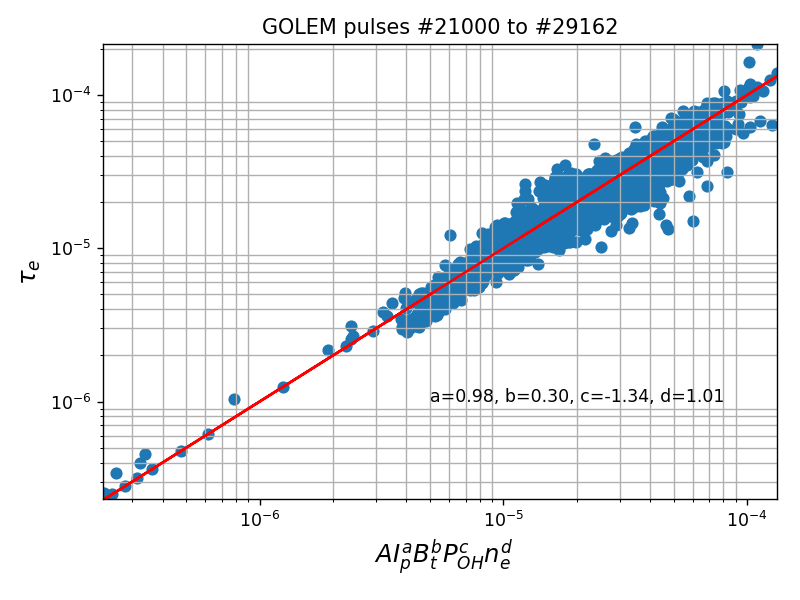

In [20]:
tau_scale = np.exp(lin_reg.intercept_) * \
        dataset_sl['plasma_current_mean']**coefs[0] * \
        dataset_sl['toroidal_field_mean']**coefs[1] * \
        dataset_sl['input_power_plasma_mean']**coefs[2] * \
        dataset_sl['pressure']**coefs[3] * \
        dataset_sl['R']**coefs[4]

fig, ax = plt.subplots()
ax.scatter(tau_scale, dataset_sl['electron_confinement_time'])
ax.plot(tau_scale, tau_scale, color='r')
ax.set_xlim(np.amin(tau_scale), np.amax(tau_scale))
ax.set_ylim(dataset_sl['electron_confinement_time'].min(), dataset_sl['electron_confinement_time'].max())
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='minor')
ax.set_xlabel(r' $ A I_p^a B_t^b P_{OH}^c n_e^d $', fontsize=14)
ax.set_ylabel(r'$ \tau_e $ [s]', fontsize=14)
ax.text(0.5e-5, 1e-6, f'a={coefs[0]:0.2f}, b={coefs[1]:0.2f}, c={coefs[2]:0.2f}, d={coefs[3]:0.2f}')
ax.set_title(f'GOLEM pulses #{dataset.index[0]} to #{dataset.index[-1]}')
fig.tight_layout()

fig.savefig('GOLEM_Tau_scaling_law.png')